In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

import albumentations
from albumentations import augmentations
import albumentations.pytorch

In [13]:
root_folder = "Image_Manipulation_Dataset"

def load_images(row):

    image_patch, mask_patch, label, _, ela, root_dir = row

    #------------- Load image, Ela, Mask -------------------------
    image_path = os.path.join(root_folder, root_dir, image_patch)
    ela_path = os.path.join(root_folder, root_dir, ela)

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    ela_image = cv2.imread(ela_path, cv2.IMREAD_COLOR)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2RGB)

    if not isinstance(mask_patch, str) and np.isnan(mask_patch):
        mask_image = np.zeros((image.shape[0], image.shape[1])).astype('uint8')
    else:
        mask_path = os.path.join(root_folder, root_dir, mask_patch)
        mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # if('NIST' in root_dir): # Not needed if NIST16v2 is used
    #     mask_image = 255 - mask_image

    image = augmentations.geometric.functional.resize(image, 256, 256, cv2.INTER_AREA)
    mask_image = augmentations.geometric.functional.resize(mask_image, 256, 256, cv2.INTER_AREA)
    ela_image = augmentations.geometric.functional.resize(ela_image, 256, 256, cv2.INTER_AREA)

    return image, ela_image, mask_image, label


from torchvision import transforms
def get_tensors(image, ela_image, mask_image):
    #---------------- Normalize -----------------------

    image_normalize = {
        "mean": [0.4535408213875562, 0.42862278450748387, 0.41780105499276865],
        "std": [0.2672804038612597, 0.2550410416463668, 0.29475415579144293],
    }
    transNormalize = transforms.Normalize(mean=image_normalize['mean'], std=image_normalize['std'])
    transTensor = transforms.ToTensor()

    tensor_image = transTensor(image)
    tensor_ela = transTensor(ela_image)
    tensor_mask = transTensor(mask_image)

    tensor_ela = transNormalize(tensor_ela).unsqueeze(0)
    tensor_image = transNormalize(tensor_image).unsqueeze(0)
    
    return tensor_image, tensor_ela, tensor_mask
    

In [3]:
from models.merged_netv2 import Mani_FeatX
from models.unetpp_v2 import MyUnetPP

device = 'cuda'

encoder = Mani_FeatX(encoder_attention=None)
model = MyUnetPP(encoder)

model = nn.DataParallel(model).to(device)
model.load_state_dict(torch.load('best_weights/(ALL_TRAIN_GTX)MyUnetPP-v2-Attn(Enc-None, Dec-GCA+SCSE)_[30|06_16|04|45].h5'))

<All keys matched successfully>

In [ ]:
def get_feat_preds(row): # Single row inference
    model.eval()
    
    with torch.no_grad():
        image, ela_image, mask_image, label = load_images(row)
        image_tensor, ela_tensor, mask_tensor = get_tensors(image, ela_image, mask_image)
        
        mask_pred, label_pred = model(image_tensor.to(device), ela_tensor.to(device))

        mask_prediction = torch.sigmoid(mask_pred.cpu().detach())
        mask_gt = mask_tensor
        label_preds = torch.sigmoid(label_pred.cpu().detach())
        label_gt = label
        
    return mask_prediction, mask_gt, label_preds, label_gt

## Load Datasets for Evaluation

In [2]:
import pandas as pd
"CMFD, NIST, COVERAGE, CASIA, IMD"

def get_test_df(path, only_fake=False):
    dataframe = pd.read_csv(path)
    test_df = dataframe[dataframe["fold"].isin([1])]
    if only_fake:
        test_df = test_df[test_df["label"] == 1]

    print(
        "real:{}, fakes:{}".format(
            len(test_df[test_df["label"] == 0]), len(test_df[test_df["label"] == 1])
        )
    )
    return test_df.values


casia_test = get_test_df('dataset_csv/casia_FULL.csv')
imd_test = get_test_df('dataset_csv/imd_FULL.csv')
coverage_test = get_test_df('dataset_csv/coverage_FULL.csv')
nist_test = get_test_df('dataset_csv/nist16v2.csv')

real:749, fakes:511
real:151, fakes:144
real:10, fakes:10
real:0, fakes:80


In [ ]:
casia_full = pd.read_csv('dataset_csv/casia_FULL.csv')
casia_full = casia_full[casia_full["fold"].isin([1])]
casia_real = casia_full[casia_full['label'] == 0].sample(n=200)
casia_fake = casia_full[casia_full['label'] == 1].sample(n=100)

imd_full = pd.read_csv('dataset_csv/imd_FULL.csv')
imd_full = imd_full[imd_full["fold"].isin([1])]
imd_real = imd_full[imd_full['label'] == 0]
imd_fake = imd_full[imd_full['label'] == 1].sample(n=100)

In [ ]:
# Run evaluation on a single dataset

label = []
pred_label = []
pred_mask = []
gt_mask = []

for row in tqdm(casia_test):
    mask_predictions, mask_gt, label_preds, label_gt = get_feat_preds(row)
    
    pred_label.append(label_preds.squeeze())
    label.append(label_gt)
    pred_mask.append(mask_predictions.squeeze())
    gt_mask.append(mask_gt.squeeze())

## Calculate Metrics

In [ ]:
from sklearn.metrics import f1_score

f1_score(np.array(label) >= 0.5, np.array(pred_label) >= 0.5)

In [ ]:
from sklearn.metrics import roc_auc_score

auc, cnt = 0, 0
for gt, pr in tqdm(zip(gt_mask, pred_mask)):          
    auc += roc_auc_score(gt.ravel() >= 0.5, pr.ravel())
    cnt += 1
auc / cnt

In [ ]:
from sklearn.metrics import roc_auc_score

thrs = [0.0,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]

sample = []
auc, cnt = 0, 0
for gt, pr in tqdm(zip(gt_mask, pred_mask)):
    best, bt = -1, 0
    for thr in thrs:
        tmp = roc_auc_score(gt.numpy().ravel() >= 0.5, pr.numpy().ravel() >= thr)          
        if tmp > best: 
            best = tmp
            bt = thr
    auc += best
    cnt += 1
    sample.append((pr, gt, bt))
auc / cnt

# Single Image Inference

In [8]:
from torchvision import transforms
def get_single_tensors(image, ela_image):
    #---------------- Normalize -----------------------

    image_normalize = {
        "mean": [0.4535408213875562, 0.42862278450748387, 0.41780105499276865],
        "std": [0.2672804038612597, 0.2550410416463668, 0.29475415579144293],
    }
    transNormalize = transforms.Normalize(mean=image_normalize['mean'], std=image_normalize['std'])
    transTensor = transforms.ToTensor()

    tensor_image = transTensor(image)
    tensor_ela = transTensor(ela_image)

    tensor_ela = transNormalize(tensor_ela).unsqueeze(0)
    tensor_image = transNormalize(tensor_image).unsqueeze(0)
    
    return tensor_image, tensor_ela

tensor(0.8948)


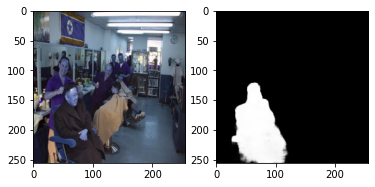

In [45]:
from utils import get_ela

image_path = 'Image_Manipulation_Dataset/IMD2020/imd_data/1a5h1p/c8ua0at_0.jpg'

image = cv2.imread(image_path, cv2.IMREAD_COLOR)
ela_image = generate_ela_PIL(image_path, 25)
# ela_image = get_ela(image, 35)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2RGB)

image = augmentations.geometric.functional.resize(image, 256, 256, cv2.INTER_AREA)
ela_image = augmentations.geometric.functional.resize(ela_image, 256, 256, cv2.INTER_AREA)

image_tensor, ela_tensor = get_single_tensors(image, ela_image)
        
mask_pred, label_pred = model(image_tensor.to(device), ela_tensor.to(device))

mask_prediction = torch.sigmoid(mask_pred.cpu().detach()).squeeze()
label_pred = torch.sigmoid(label_pred.cpu().detach()).squeeze()

print(label_pred)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask_prediction, cmap='gray')
plt.show()